# Basic QPQ vs Multilevel QPQ
 
Import some libraries

In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import beta
from scipy.ndimage.interpolation import shift
import seaborn as sns

In [2]:
from pathlib import Path

commondir = './simresults/'
Path(commondir + "images").mkdir(parents=True, exist_ok=True)

The following example shows how the liar's values are calculated. The idea is that declared values are strongly correlated with real values but slightly increase the probability of saying higher values. The way to do it is by combining the CDF of the uniform and beta distributions.

The following code generates true values following a uniform distribution.

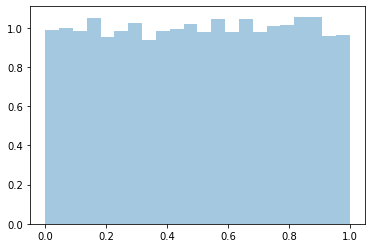

In [3]:
trueVals = stats.uniform(0, 1).rvs(10000)
sns.distplot(trueVals, kde=False, norm_hist=True);

Now, transforms the uniform values (true values) using the beta distribution.

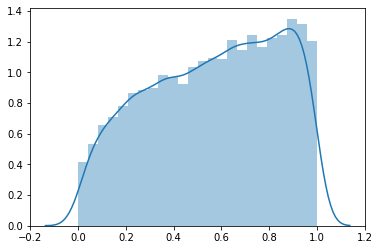

In [4]:
norm = stats.distributions.beta(1.3, 1)
declaredVals = norm.ppf(trueVals)
sns.distplot(declaredVals);

It is easy to see that declared values and true values are highly correlated, but higher values are slightly more frequent. Given that QPQ chooses low values for decisions (argmin), one possible strategy for liars would be to modify the actual values by declaring higher values more likely.

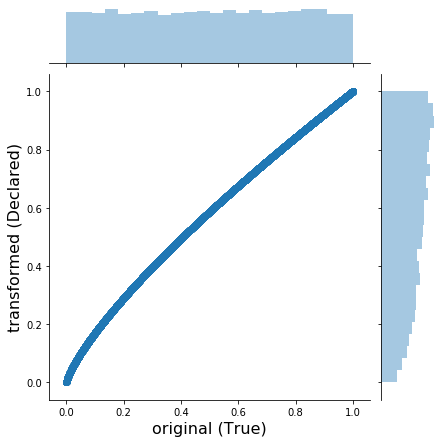

In [5]:
h = sns.jointplot(trueVals, declaredVals, stat_func=None)
h.set_axis_labels('original (True)', 'transformed (Declared)', fontsize=16);

The previous example exaggerates the beta value in order to show the technique, but the real strategy is to use lower Beta values to make liars detection more complicated. The following example could be a case of almost undetectable manipulation

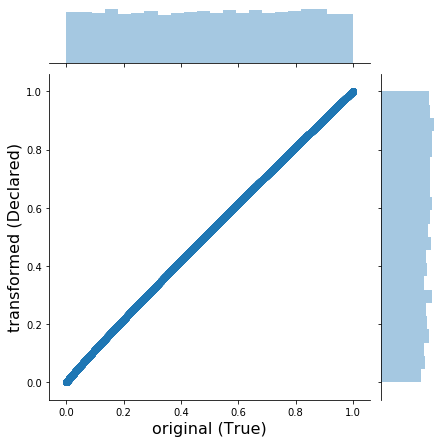

In [6]:
norm = stats.distributions.beta(1.05, 1)
declaredVals = norm.ppf(trueVals)
h = sns.jointplot(trueVals, declaredVals, stat_func=None)
h.set_axis_labels('original (True)', 'transformed (Declared)', fontsize=16);

# About KS Test

[More info at scipy.stats Web page](https://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.kstest.html)

**scipy.stats.kstest(rvs, cdf, args=(), N=20, alternative='two-sided', mode='approx')**

Perform the Kolmogorov-Smirnov test for goodness of fit.
This performs a test of the distribution G(x) of an observed random variable against a given distribution F(x). 
Under the null hypothesis the two distributions are identical, G(x)=F(x). The alternative hypothesis can be either ‘two-sided’ (default), ‘less’ or ‘greater’. The KS test is only valid for continuous distributions.

Draw samples from the uniform distribution:

In [7]:
s = np.random.uniform(0, 1, 1000)

Display the histogram of the samples, along with the probability density function:

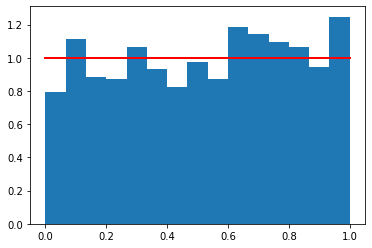

In [8]:
count, bins, ignored = plt.hist(s, 15, density=True)
plt.plot(bins, np.ones_like(bins), linewidth=2, color='r')
plt.show()

Test against ‘two-sided’ alternative hypothesis uniform. The null-hypothesis for the KT test is that the distributions are the same. Thus, the lower your p value the greater the statistical evidence you have to reject the null hypothesis and conclude the distributions are different.

In [9]:
stats.kstest(s, 'uniform')

KstestResult(statistic=0.04981619717156205, pvalue=0.013500491505932284)

Computing False-Negatives proportion

In [10]:
# Number of simulations
numberSimulation = 50000

# History length
historyLen = 100

pvalues = []
for i in range(numberSimulation):
    # s = np.random.beta(1, 1.1, historyLen)
    s = np.random.uniform(0, 1, historyLen)
    ks = stats.kstest(s, 'uniform')
    pvalues.append(ks)

df = pd.DataFrame(data=pvalues)
df.head(10)

,statistic,pvalue
0,0.092024,0.345978
1,0.096297,0.293612
2,0.111992,0.150831
3,0.107775,0.182168
4,0.071145,0.693840
5,0.068544,0.747439
6,0.090238,0.369718
7,0.093197,0.330977
8,0.061304,0.846562
9,0.057279,0.898138


In [11]:
df2 = df[df.pvalue < 0.2]['pvalue']
len(df2)

9933

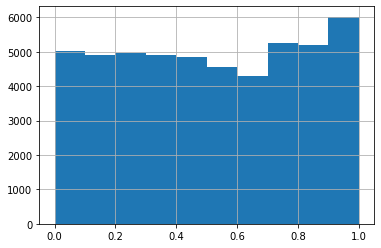

In [12]:
hist = df['pvalue'].hist()

# Terminology
First, let's introduce some terminology

- **condition positive (P)**: the number of real positive cases in the data (number of true values. Players are honest)
- **condition negative (N)**: the number of real negative cases in the data (number of false declarations. Players are dishonest)

- **true positive (TP)**: These are cases in which we predicted yes (they are honest), and they are honest. Also known as a hit
- **true negative (TN)**: We predicted no (they are dishonest), and they are dishonest. Also known as a correct anwser.
- **false positive (FP)**: We predicted yes (they are honest), but they are dishonest. Also known as a "Type I error" or false alarm.
- **false negative (FN)**: We predicted no (they are dishonest), but they actually are honest. Also known as a miss or "Type II error"


We are interested on:
- reducing FN rate. Each FN reduces the utility of the player (if we use argmax in QPQ or increases when using argmin).
- increasing TN rate. Dishonest player should be detected as much as possible.

# KS test at Level 1

This analysis is within a cluster (inferior level or level 1). 

## Honest Players
At this point, we want to compute TP and FN when every player is honest. In this case, N, TN and FP are cero. And we want to compute the TP and FN rates at different history lengths.

The goal is to have FN as low as possible.

In [13]:
# Number of simulations
numberSimulation = 5000

# History length
historyLenRange = range(100, 2100, 100)

thresholdRange = range(75, 100, 5)

debug = False

results = {'HL': [],'TH': [], 'P': [],'N': [],
           'TP': [], 'TN': [], 'FP': [], 'FN': [],
           'TPRate': [], 'TNRate': [], 'FPRate': [], 'FNRate': []}
for threshold in thresholdRange:
    threshold = threshold / 100
    print("Threshold:", threshold)
    for historyLen in historyLenRange:
        #print("   historyLen:", historyLen)
        pvalues = []
        for i in range(numberSimulation):
            # Draw samples from a uniform distribution.
            # Samples are uniformly distributed over the half-open interval [low, high) (includes low, but excludes high).
            s = np.random.uniform(low=0, high=1, size=historyLen)
            ks = stats.kstest(s, 'uniform')
            pvalues.append(ks)

        df = pd.DataFrame(data=pvalues)
        FN = len(df[df.pvalue < 1 - threshold])
        TP = len(df[df.pvalue >= 1- threshold])
        if debug:
            print("      False negative:", (FN))
            print("      True positive:", (TP))
            assert (numberSimulation == FN + TP), "The number of simulations does not match!"
            print("      Threshold:", threshold)
            print("      False negative rate:", (FN/numberSimulation))
            print("      True positive rate:", (TP/numberSimulation))
        results['HL'].append(historyLen)
        results['TH'].append(threshold)
        results['P'].append(numberSimulation)
        results['N'].append(0)
        results['TP'].append(TP)
        results['TN'].append(0)
        results['FP'].append(0)
        results['FN'].append(FN)
        results['TPRate'].append(TP/numberSimulation)
        results['TNRate'].append(0)
        results['FPRate'].append(0)
        results['FNRate'].append(FN/numberSimulation)
    df = pd.DataFrame(data=results)

Threshold: 0.75
Threshold: 0.8
Threshold: 0.85
Threshold: 0.9
Threshold: 0.95


In [14]:
df.head(10)

,HL,TH,P,N,TP,TN,FP,FN,TPRate,TNRate,FPRate,FNRate
0,100,0.75,5000,0,3741,0,0,1259,0.7482,0,0,0.2518
1,200,0.75,5000,0,3705,0,0,1295,0.7410,0,0,0.2590
2,300,0.75,5000,0,3727,0,0,1273,0.7454,0,0,0.2546
3,400,0.75,5000,0,3735,0,0,1265,0.7470,0,0,0.2530
4,500,0.75,5000,0,3748,0,0,1252,0.7496,0,0,0.2504
5,600,0.75,5000,0,3719,0,0,1281,0.7438,0,0,0.2562
6,700,0.75,5000,0,3768,0,0,1232,0.7536,0,0,0.2464
7,800,0.75,5000,0,3744,0,0,1256,0.7488,0,0,0.2512
8,900,0.75,5000,0,3748,0,0,1252,0.7496,0,0,0.2504
9,1000,0.75,5000,0,3758,0,0,1242,0.7516,0,0,0.2484


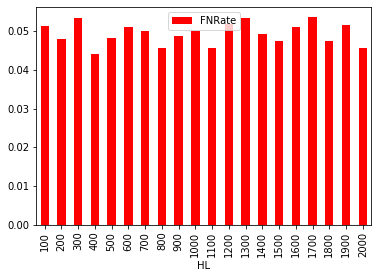

In [15]:
df95 = df[df.TH == 0.95]
df95.plot(kind='bar',x='HL',y='FNRate',color='red')
plt.show()

As we can see, the FN rate is constant regardless of the history length.

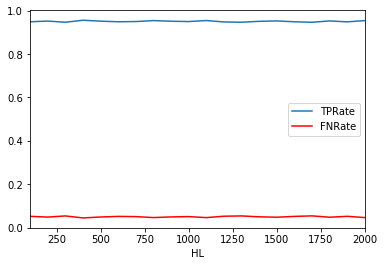

In [16]:
ax = plt.gca()

df95.plot(kind='line',x='HL',y='TPRate',ax=ax)
df95.plot(kind='line',x='HL',y='FNRate', color='red', ax=ax)

plt.show()

And it is also easy to see that:
$$TP = threshold$$
$$FN = 1 - threshold$$

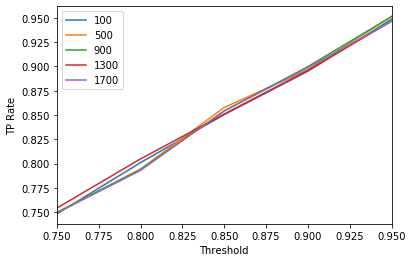

In [17]:
ax = plt.gca()

for HL in  range(100, 2100, 400):
    dfTmp = df[df.HL == HL]
    dfTmp.plot(kind='line',x='TH',y='TPRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("TP Rate")
ax.legend(loc='best')

plt.show()

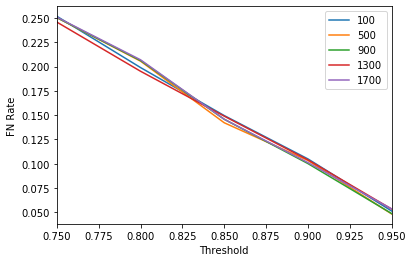

In [18]:
ax = plt.gca()

for HL in  range(100, 2100, 400):
    dfTmp = df[df.HL == HL]
    dfTmp.plot(kind='line',x='TH',y='FNRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("FN Rate")
ax.legend(loc='best')

plt.show()

## Dishonest Players
Now, we want to compute the confusion matrix when the player is dishonet following a beta. In this case, P, TP and FN are cero. 

And we want to compute those TN and FP rates with different history lengths.

The goal is to have TP as high as possible.

In [19]:
# Number of simulations
numberSimulation = 5000

# History length
historyLenRange = range(100, 550, 50) #  range(100, 2100, 400)

thresholdRange = range(90, 100, 5)

betaFactor = 1.1
betaDistr = stats.distributions.beta(betaFactor, 1)
    
debug = False

results = {'HL': [],'TH': [], 'P': [],'N': [],
           'TP': [], 'TN': [], 'FP': [], 'FN': [],
           'TPRate': [], 'TNRate': [], 'FPRate': [], 'FNRate': []}
for threshold in thresholdRange:
    threshold = threshold / 100
    print("Threshold:", threshold)
    for historyLen in historyLenRange:
        #print("   historyLen:", historyLen)
        pvalues = []
        for i in range(numberSimulation):
            trueVals = np.random.uniform(0, 1, historyLen)
            declaredVals = betaDistr.ppf(trueVals)
            ks = stats.kstest(declaredVals, 'uniform')
            pvalues.append(ks)

        df = pd.DataFrame(data=pvalues)
        TN = len(df[df.pvalue < 1 - threshold])
        FP = len(df[df.pvalue >= 1 - threshold])
        if debug:
            print("      False positive:", (FP))
            print("      True negative:", (TN))
            assert (numberSimulation == FP + TN), "The number of simulations does not match!"
            print("      Threshold:", threshold)
            print("      False positive rate:", (FP/numberSimulation))
            print("      True negative rate:", (TN/numberSimulation))
        results['HL'].append(historyLen)
        results['TH'].append(threshold)
        results['P'].append(0)
        results['N'].append(numberSimulation)
        results['TP'].append(0)
        results['TN'].append(TN)
        results['FP'].append(FP)
        results['FN'].append(0)
        results['TPRate'].append(0)
        results['TNRate'].append(TN/numberSimulation)
        results['FPRate'].append(FP/numberSimulation)
        results['FNRate'].append(0)
    df = pd.DataFrame(data=results)

Threshold: 0.9
Threshold: 0.95


In [20]:
df.head(20)

,HL,TH,P,N,TP,TN,FP,FN,TPRate,TNRate,FPRate,FNRate
0,100,0.90,0,5000,0,939,4061,0,0,0.1878,0.8122,0
1,150,0.90,0,5000,0,1162,3838,0,0,0.2324,0.7676,0
2,200,0.90,0,5000,0,1362,3638,0,0,0.2724,0.7276,0
3,250,0.90,0,5000,0,1594,3406,0,0,0.3188,0.6812,0
4,300,0.90,0,5000,0,1809,3191,0,0,0.3618,0.6382,0
5,350,0.90,0,5000,0,2056,2944,0,0,0.4112,0.5888,0
6,400,0.90,0,5000,0,2189,2811,0,0,0.4378,0.5622,0
7,450,0.90,0,5000,0,2400,2600,0,0,0.4800,0.5200,0
8,500,0.90,0,5000,0,2596,2404,0,0,0.5192,0.4808,0
9,100,0.95,0,5000,0,564,4436,0,0,0.1128,0.8872,0


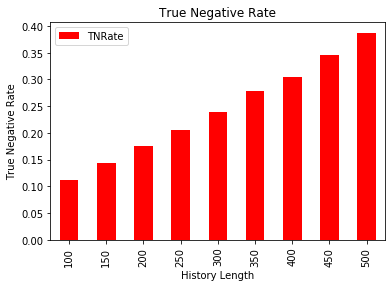

In [21]:
df95 = df[df.TH == 0.95]
df95.plot(kind='bar',x='HL',y='TNRate',color='red')
#plt.show()
plt.title("True Negative Rate")
plt.xlabel("History Length")
plt.ylabel("True Negative Rate");
plt.legend()
plt.savefig(commondir + 'images/FNRate.pdf', format='pdf')

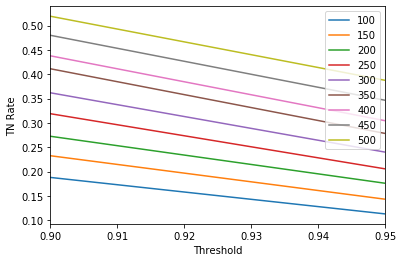

In [22]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[df.HL == HL]
    dfTmp.plot(kind='line',x='TH',y='TNRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("TN Rate")
ax.legend(loc='best')

plt.show()

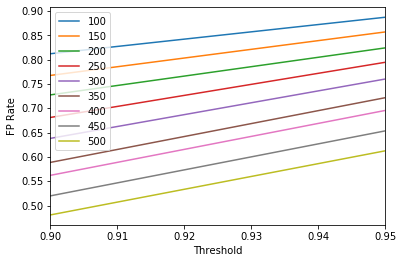

In [23]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[df.HL == HL]
    dfTmp.plot(kind='line',x='TH',y='FPRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("FP Rate")
ax.legend(loc='best')

plt.show()

# KS test at Level 0

Now, we do the same analysis but at level 0 (superior level where players are clusters)

## Honest Clusters
At this point, we want to compute TP and FN when every cluster is honest. In this case, N, TN and FP are cero. And we want to compute the TP and FN rates at different history lengths.

The goal is to have FN as low as possible.

In [24]:
# Number of simulations
numberSimulation = 5000

# History length
historyLenRange = range(100, 2100, 100)

thresholdRange = range(75, 100, 5)

debug = False

playersPerClusterRange = range(4, 20, 4)

results = {'players': [], 'HL': [], 'TH': [], 'P': [],'N': [],
           'TP': [], 'TN': [], 'FP': [], 'FN': [],
           'TPRate': [], 'TNRate': [], 'FPRate': [], 'FNRate': []}
for playersPerCluster in playersPerClusterRange:
    print("Players Per Cluster:", playersPerCluster)
    for threshold in thresholdRange:
        threshold = threshold / 100
        print("  Threshold:", threshold)
        for historyLen in historyLenRange:
            #print("   historyLen:", historyLen)
            pvalues = []
            for i in range(numberSimulation):
                s =  np.random.beta(a=1., b=playersPerCluster, size=historyLen)
                ks = stats.kstest(s, stats.beta(a=1., b=playersPerCluster).cdf)
                pvalues.append(ks)

            df = pd.DataFrame(data=pvalues)
            TP = len(df[df.pvalue < threshold])
            FN = len(df[df.pvalue >= threshold])
            if debug:
                print("      False negative:", (FN))
                print("      True positive:", (TP))
                assert (numberSimulation == FN + TP), "The number of simulations does not match!"
                print("      Threshold:", threshold)
                print("      False negative rate:", (FN/numberSimulation))
                print("      True positive rate:", (TP/numberSimulation))
            results['players'].append(playersPerCluster)
            results['HL'].append(historyLen)
            results['TH'].append(threshold)
            results['P'].append(numberSimulation)
            results['N'].append(0)
            results['TP'].append(TP)
            results['TN'].append(0)
            results['FP'].append(0)
            results['FN'].append(FN)
            results['TPRate'].append(TP/numberSimulation)
            results['TNRate'].append(0)
            results['FPRate'].append(0)
            results['FNRate'].append(FN/numberSimulation)
        df = pd.DataFrame(data=results)

Players Per Cluster: 4
  Threshold: 0.75
  Threshold: 0.8
  Threshold: 0.85
  Threshold: 0.9
  Threshold: 0.95
Players Per Cluster: 8
  Threshold: 0.75
  Threshold: 0.8
  Threshold: 0.85
  Threshold: 0.9
  Threshold: 0.95
Players Per Cluster: 12
  Threshold: 0.75
  Threshold: 0.8
  Threshold: 0.85
  Threshold: 0.9
  Threshold: 0.95
Players Per Cluster: 16
  Threshold: 0.75
  Threshold: 0.8
  Threshold: 0.85
  Threshold: 0.9
  Threshold: 0.95


In [25]:
df.head(10)

,players,HL,TH,P,N,TP,TN,FP,FN,TPRate,TNRate,FPRate,FNRate
0,4,100,0.75,5000,0,3533,0,0,1467,0.7066,0,0,0.2934
1,4,200,0.75,5000,0,3606,0,0,1394,0.7212,0,0,0.2788
2,4,300,0.75,5000,0,3683,0,0,1317,0.7366,0,0,0.2634
3,4,400,0.75,5000,0,3598,0,0,1402,0.7196,0,0,0.2804
4,4,500,0.75,5000,0,3706,0,0,1294,0.7412,0,0,0.2588
5,4,600,0.75,5000,0,3684,0,0,1316,0.7368,0,0,0.2632
6,4,700,0.75,5000,0,3684,0,0,1316,0.7368,0,0,0.2632
7,4,800,0.75,5000,0,3716,0,0,1284,0.7432,0,0,0.2568
8,4,900,0.75,5000,0,3671,0,0,1329,0.7342,0,0,0.2658
9,4,1000,0.75,5000,0,3714,0,0,1286,0.7428,0,0,0.2572


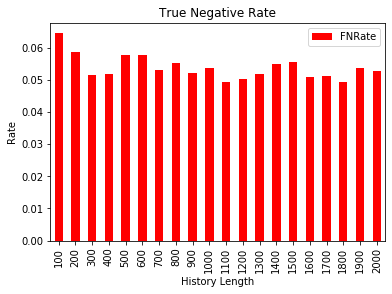

In [26]:
dfp4th95 = df[(df.TH == 0.95) & (df.players == 16)]
dfp4th95.plot(kind='bar',x='HL',y='FNRate',color='red')
#plt.show()
plt.title("True Negative Rate")
plt.xlabel("History Length")
plt.ylabel("Rate");
plt.legend()
plt.savefig(commondir + 'images/FNRate.pdf', format='pdf')

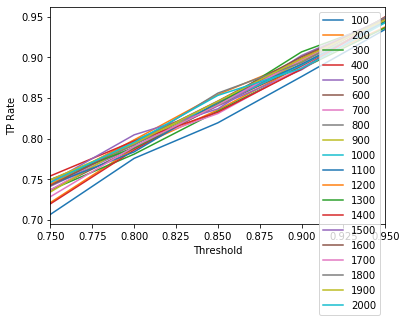

In [27]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[(df.HL == HL) & (df.players == 4)]
    dfTmp.plot(kind='line',x='TH',y='TPRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("TP Rate")
ax.legend(loc='best')

plt.show()

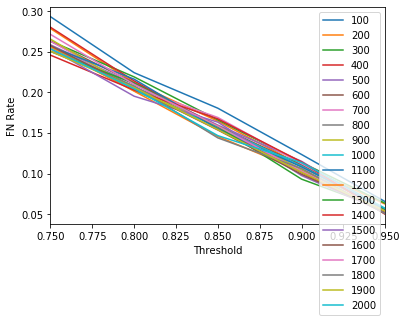

In [28]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[(df.HL == HL) & (df.players == 4)]
    dfTmp.plot(kind='line',x='TH',y='FNRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("FN Rate")
ax.legend(loc='best')

plt.show()

## Dishonest Clusters
Now, we want to compute the confusion matrix when the cluster is dishonet following a beta with higher alpha parameter. In this case, P, TP and FN are cero. 

And we want to compute those TN and FP rates with different history lengths.

The goal is to have TP as high as possible.

In [ ]:
# Number of simulations
numberSimulation = 5000

# History length
historyLenRange = range(100, 2100, 100)

thresholdRange = range(75, 100, 5)

betaFactor = 1.1
    
debug = False

playersPerClusterRange = range(4, 20, 4)

results = {'players': [], 'HL': [], 'TH': [], 'P': [],'N': [],
           'TP': [], 'TN': [], 'FP': [], 'FN': [],
           'TPRate': [], 'TNRate': [], 'FPRate': [], 'FNRate': []}
for playersPerCluster in playersPerClusterRange:
    print("Players Per Cluster:", playersPerCluster)
    for threshold in thresholdRange:
        threshold = threshold / 100
        print("Threshold:", threshold)
        for historyLen in historyLenRange:
            #print("   historyLen:", historyLen)
            pvalues = []
            for i in range(numberSimulation):
                trueVals =  np.random.beta(a=1., b=playersPerCluster, size=historyLen)
                betaDistr = stats.distributions.beta(betaFactor, playersPerCluster)
                declaredVals = betaDistr.ppf(trueVals)
                ks = stats.kstest(s, stats.beta(a=1., b=playersPerCluster).cdf)
                pvalues.append(ks)

            df = pd.DataFrame(data=pvalues)
            FP = len(df[df.pvalue < threshold])
            TN = len(df[df.pvalue >= threshold])
            if debug:
                print("      False positive:", (FP))
                print("      True negative:", (TN))
                assert (numberSimulation == FP + TN), "The number of simulations does not match!"
                print("      Threshold:", threshold)
                print("      False positive rate:", (FP/numberSimulation))
                print("      True negative rate:", (TN/numberSimulation))
            results['players'].append(playersPerCluster)
            results['HL'].append(historyLen)
            results['TH'].append(threshold)
            results['P'].append(0)
            results['N'].append(numberSimulation)
            results['TP'].append(0)
            results['TN'].append(TN)
            results['FP'].append(FP)
            results['FN'].append(0)
            results['TPRate'].append(0)
            results['TNRate'].append(TN/numberSimulation)
            results['FPRate'].append(FP/numberSimulation)
            results['FNRate'].append(0)
        df = pd.DataFrame(data=results)

Players Per Cluster: 4
Threshold: 0.75
Threshold: 0.8
Threshold: 0.85


In [ ]:
df.head(10)

In [ ]:
df95 = df[(df.TH == 0.95) & (df.players == 8)]
df95.plot(kind='bar',x='HL',y='TNRate',color='red')
plt.show()

In [ ]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[(df.HL == HL) & (df.players == 8)]
    dfTmp.plot(kind='line',x='TH',y='TNRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("TN Rate")
ax.legend(loc='best')

plt.show()

In [ ]:
ax = plt.gca()

for HL in historyLenRange:
    dfTmp = df[(df.HL == HL) & (df.players == 4)]
    dfTmp.plot(kind='line',x='TH',y='FPRate',ax=ax,label=HL)


ax.set_xlabel("Threshold")
ax.set_ylabel("FP Rate")
ax.legend(loc='best')

plt.show()

# Threshold Function

So, we know that the FN rate functions for QPQ and QPQ2 are:

FN Rate of QPQ = 1 - th <- independent of historyLen (for the p-value of the KS test)
FN Rate of QPQ2 = 1 - thc * thu <- independent of historyLen (for the p-value of the KS test)

Making the two thresholds at QPQ2 $thc = thu = th2$

$FN_{QPQ1} = 1 - th$

$FN_{QPQ2} = 1 - (th2) * (th2)$
 
$FN_{QPQ1} = FN_{QPQ2}$

$1 - th = 1 - (th2) * (th2)$
 
$th = th2 ** 2$
 
$th2 = sqrt (th)$
 

We call $f (x)$ the treshold function that given a history len returns the threshold. This function also gives the probability of not having an FN if the story has length x.

We want that using the same amount of memory, when all are honest, the probability of an FN is the same in QPQ and QPQ2:

$f ((historyLen * numplayers) / (numclusters + alpha * numplayers / numclusters)) = sqrt (f (historyLen))$

Because in each player with QPQ numplayers historyLen memory is used. In QPQ2 I have

$(historyLen * numplayers) / (numclusters + alpha * numplayers / numclusters)$

if 

$x = historyLen$

$a = numplayers * numclusters / ( numclusters ^ 2 + numplayers )$

then

$f (a x) = sqrt (f (x))$

Solving ...

$f (x) = e ^ {c 2 ^ {1 - log (x) / log (a)}}$

That when $c < 0$ has the form we want (increasing with x asymptotically 1)

https://www.wolframalpha.com/input/?i=plot+%7Be+%5E+%7B-2%5E%281+-+log%28x%29%2Flog%285%29%29%7D+%7D+from+10+to+5000

To choose $c$ we can set the threshold value to $th_0$ for a fixed history length value $historyLen = x_0$

The value of $c$ depends on $a$, $th_0$ and $x_0$ and has the expression:

$c = ln (th_0) * 2 ^ {- 1 + log (x_0) / log (a)}$

That is always negative as we want when $th_0 < 1$

Entering c in the previous expression:

$f (x) = e ^ {ln (th_0) * 2 ^ {log (x_0 / x) / log (a)}}$

$ = e ^ {ln (th_0) 2 ^ {log_a (x_0 / x)}}$

$ = th_0 ^ {(x_0 / x) ^ {1 / log_2 a}}$

Before continuing we want to plot some examples just to verify that they have the appropriate form. 

In the following figure, we plot this function using $a=2, th_0=0.97, x_0=100$

In [ ]:
def thresholdLevel(x, a, th0=0.97, x0=100): return (th0)**((x0/x)**(1/math.log2(a)))

hl1 = np.arange(100, 5000, 100)

plt.plot(hl1, thresholdLevel(hl1, 2))

In previous simulations, an empirical function was being used. That function was:

`def thresholdLevel(th, hl, minhl=40): return (1 - th)*10/(hl - minhl)`

if we plot both funcions for $a=2, th_0=0.97, x_0=100$ we can see that both functions behave in the same way:

In [ ]:
def empiricalThresholdLevel(hl, th=0.80, minhl=30): return 1 - (1 - th)*10/(hl - minhl)

print (empiricalThresholdLevel(100))

hl1 = np.arange(100, 5000, 100)

plt.figure()
plt.subplot(211)
plt.plot(hl1, thresholdLevel(hl1, 2))
plt.title('Analytical function')
plt.subplot(212)
plt.plot(hl1, empiricalThresholdLevel(hl1))
plt.title('Empirical function')
# Adjust the subplot layout
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.50, wspace=0.35)
plt.show()

# Basic QPQ algorithm


- 1: Estimate the preference $θ_i(r)$
- 2: Calculate the normalized preference  ̄$\bar{θ}_i(r) = PIT(θ_i(r))$
- 3: Declare a value $θ_i(r)$ that represents her normalized preference.
- 4: Wait to receive the published normalized preferences  ̇$θ_j(r)$ from all players
- 5: For all $j \in N$ do
    - 6: if not GoF_Test($θ_j(r), Historic_j$) then
        - 7:  ̈$θ_j (r) ← \hat{θ}_j(r)$, where $\hat{θ}_j(r)$ := Pseudorandom($θ_j(r)$)
    - 8: else
        - 9:  ̈$θ_j(r)$ ←  ̇$θ_j(r)$
    - 10: end if
    - 11: $Historic_j$ ← $Historic_j ∪ \{ θ_j(r) \}$
- 12: end for
- 13: Let $d = arg max_{j∈N} \{ ̈θ_j(r)\}$
- 14: if $d = i$ then
    - 15: Player i gets resource r
- 16: end if

In [ ]:
# Values is a matrix (N x r) or (number of playes x number of rounds)
def QPQ(declaredVals, trueVals, histlen, maxpval, KSTest=True, debug=True):
    dims = declaredVals.shape
    N = dims[0] # number of players
    R = dims[1] # number of rounds
    decisions = np.full(R, np.nan)
    historic = np.full((N, histlen), np.nan) # Empty history matrix (N x histlen) or (number of playes x History Len)
    
    utilities = np.zeros((N, R)) # Empty utility matrix (N x R)
    falsenegatives = np.zeros((N, R)) # Empty utility matrix (N x R)
    for i in range(R):
        # Roll historic to the left
        if (i > histlen):
            historic = np.roll(historic, -1, axis=1)
            
        theta = np.zeros(N)
        # copy declared values at the end of the historic
        historic[:, min(i, histlen - 1)] = declaredVals[: , i]
        
        for j in range(N):
            if debug: 
                print ("player ", j, " has values ", historic[j])
            if KSTest and stats.kstest(historic[j, 0:min(i+1, histlen)], 'uniform').pvalue < (1 - maxpval):
                if debug: print("False negative")
                theta[j] = np.random.uniform(0, 1, 1)
                falsenegatives[j, i] = 1
            else:
                theta[j] = declaredVals[j, i]
                
        # copy declared values at the end of the historic
        historic[:, min(i, histlen - 1)] = theta
        
        d = int(np.argmin(theta))
        if debug: print("Win player ", d)
        decisions[i] = d
        utilities[d, i] = trueVals[d, i]
    return decisions, utilities, falsenegatives

In [ ]:
numplayers = 4
numLiars = 1
rounds = 1000
historyLen = 100
numberSimulations = 10
threshold = 0.95
betaFactor = 1.5

util1F  = np.full((numberSimulations, numplayers), np.nan)
falseneg1F  = np.full((numberSimulations, numplayers), np.nan)
util1T  = np.full((numberSimulations, numplayers), np.nan)
falseneg1T  = np.full((numberSimulations, numplayers), np.nan)

for k in range(numberSimulations):
    trueVals = np.random.uniform(0, 1, (numplayers, rounds))
    declaredVals = np.array(trueVals, copy=True)

    norm = stats.distributions.beta(betaFactor, 1)
    declaredVals[0:numLiars, :] = norm.ppf(trueVals[0:numLiars, :])

    #h = sns.jointplot(trueVals[0,:], declaredVals[0,:], stat_func=None)
    #h.set_axis_labels('original (True)', 'transformed (Declared)', fontsize=16);
    #h = sns.jointplot(trueVals[1,:], declaredVals[1,:], stat_func=None)
    #h.set_axis_labels('original (True)', 'transformed (Declared)', fontsize=16);


    rst1F, ut1F, fn1F = QPQ(declaredVals, trueVals, historyLen, threshold, KSTest=False, debug=False)
    rst1T, ut1T, fn1T = QPQ(declaredVals, trueVals, historyLen, threshold, KSTest=True, debug=False)


    util1F[k, :] = ut1F.mean(axis = 1)
    falseneg1F[k, :] = fn1F.mean(axis = 1)
    util1T[k, :] = ut1T.mean(axis = 1)
    falseneg1T[k, :] = fn1T.mean(axis = 1)
    
print("QPQ Player Utility without KS", util1F.mean(axis = 0))
print("QPQ Player Utility with KS", util1T.mean(axis = 0))
print("QPQ False Negative per player without KS", falseneg1F.mean(axis = 0))
print("QPQ False Negative per player with KS", falseneg1T.mean(axis = 0))

# Multilevel QPQ algorithm

TODO

In [ ]:
# Values is a matrix (N x r) or (number of playes x number of rounds)
# Level 0 is base level 
# Level 1 is cluster level
def QPQ2Level(declaredVals, trueVals, K, histlenL0, maxpvalL0, histlenL1, maxpvalL1, KSTest=True, debug=True):
    dims = declaredVals.shape
    N = dims[0] # number of players
    R = dims[1] # number of rounds
    playersPerCluster = int(N/K)
    if debug:
        print("Number of players ", N)
        print("Number of clusters ", K)
        print("Number of players per Cluster ", playersPerCluster)
    decisions = np.full(R, np.nan)
    historicL0 = np.full((N, histlenL0), np.nan) # Empty history matrix (N x histlen) or (number of playes x History Len)
    historicL1 = np.full((K, histlenL1), np.nan)
    utilities = np.zeros((N, R)) # Empty utility matrix (N x R)
    falsenegativesL0 = np.zeros((N, R)) # Empty utility matrix (N x R)
    falsenegativesL1 = np.zeros((K, R)) # Empty utility matrix (K x R)
    falsenegativesBoth = np.zeros((N, R)) # Empty utility matrix (N x R)
    for i in range(R):
        # Roll historic to the left
        if (i > histlenL0):
            historicL0 = np.roll(historicL0, -1, axis=1)
            
        theta = np.zeros(N)
        # copy declared values at the end of the historic
        historicL0[:, min(i, histlenL0 - 1)] = declaredVals[: , i]

        for j in range(N):
            if debug: 
                print ("player ", j, " has values ", historicL0[j])
            if KSTest and stats.kstest(historicL0[j, 0:min(i+1, histlenL0)], 'uniform').pvalue < (1 - maxpvalL0):
                if debug: print("False negative")
                theta[j] = np.random.uniform(0, 1, 1)
                falsenegativesL0[j, i] = 1
            else:
                theta[j] = declaredVals[j, i]
                
        # copy declared values at the end of the historic
        historicL0[:, min(i, histlenL0 - 1)] = theta
        
        thetaUp = np.zeros(K)
        decisionsL1 = np.full(K, np.nan)
        for k in range(K):     
            valsCluster = theta[(k)*playersPerCluster:(k+1)*playersPerCluster]
            decisionsL1[k] = int(np.argmin(valsCluster))
            player = int((k)*playersPerCluster + decisionsL1[k])
            if debug: 
                print ("cluster ", k, " has values ", valsCluster)
                print ("cluster ", k, " has player ", player)
                print ("cluster ", k, " has value ", valsCluster[int(decisionsL1[k])])
                print ("cluster ", k, " has range ", (k, min(i, histlenL1 - 1)))
            historicL1[k, min(i, histlenL1 - 1)] = valsCluster[int(decisionsL1[k])]
            if KSTest and stats.kstest(historicL1[k, 0:min(i+1, histlenL1)], stats.beta(a=1., b=playersPerCluster).cdf).pvalue < (1 - maxpvalL1):
                if debug: print("False negative")
                thetaUp[k] = np.random.uniform(0, 1, 1)
                falsenegativesL1[k, i] = 1
                falsenegativesBoth[player, i] = 1
            else:
                thetaUp[k] = valsCluster[int(decisionsL1[k])]
                
        #print(thetaUp)        
        dCluster = np.argmin(thetaUp)
        d = int(dCluster*playersPerCluster + decisionsL1[dCluster])
        if debug: print("Win cluster ", dCluster, " and player ", d)
        decisions[i] = d
        utilities[d, i] = trueVals[d, i]
    return decisions, utilities, falsenegativesL0, falsenegativesL1, falsenegativesBoth

In [ ]:
numplayers = 4
numclusters = 2
numLiars = 1
rounds = 1000
historyLen = 100
alpha = 1 
hlL0 = int((historyLen * numplayers) / (numclusters + alpha * numplayers / numclusters))
hlL1 = int(alpha * hlL0)

# memoria disponible = hlL0 * numclusters +  hlL1 * (numplayers / numclusters) = historyLen * numplayers
# suponiendo hlL1 = alpha * hlL0 entonces:
#   hlL0 = (historyLen * numplayers) / (numclusters + alpha * numplayers / numclusters)
# y alpha =  hlL1 / hlL0

# falso negativo = 1 - (1 -  pvc)*(1 - pvu) <-- independiente de la historyLen
# pv = 1 - (1 -  pvc)(1 - pvu) ==>  pvu = 1 - (1 - pv)/(1 -  pvc)  
# pvc = pvu = 1 - sqrt(1 - pv) = cte1 / hlL1 = cte0 / hlL0
# negativo cierto en beta SI depende de la historia

numberSimulations = 10
thresholdL0 = 0.98
thresholdL1 = 0.95
betaFactor = 1.5

util2F  = np.full((numberSimulations, numplayers), np.nan)
falseneg2F  = np.full((numberSimulations, numplayers), np.nan)
util2T  = np.full((numberSimulations, numplayers), np.nan)
falseneg2T  = np.full((numberSimulations, numplayers), np.nan)

for k in range(numberSimulations):
    trueVals = np.random.uniform(0, 1, (numplayers, rounds))
    declaredVals = np.array(trueVals, copy=True)

    norm = stats.distributions.beta(betaFactor, 1)
    declaredVals[0:numLiars, :] = norm.ppf(trueVals[0:numLiars, :])

    rst2F, ut2F, fn2F, fnc2F, fnb2F = QPQ2Level(declaredVals, trueVals, numclusters, hlL0, thresholdL0, hlL1, thresholdL1, KSTest=False, debug=False)
    rst2T, ut2T, fn2T, fnc2T, fnb2T = QPQ2Level(declaredVals, trueVals, numclusters, hlL0, thresholdL0, hlL1, thresholdL1, KSTest=True, debug=False)


    util2F[k, :] = ut2F.mean(axis = 1)
    falseneg2F[k, :] = fn2F.mean(axis = 1)
    util2T[k, :] = ut2T.mean(axis = 1)
    falseneg2T[k, :] = fn2T.mean(axis = 1)
    
print("QPQ2 Player Utility without KS", util2F.mean(axis = 0))
print("QPQ2 Player Utility with KS", util2T.mean(axis = 0))
print("QPQ2 False Negative per player without KS", falseneg2F.mean(axis = 0))
print("QPQ2 False Negative per player with KS", falseneg2T.mean(axis = 0))